In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
dtype_train = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

In [4]:
## print out the first 5 rows of each dataset
holidays0 = pd.read_csv("./data/holidays_events.csv")
oil0 = pd.read_csv("./data/oil.csv")
stores0 = pd.read_csv("./data/stores.csv")
train0 = pd.read_csv("./data/train.csv"
                     ,dtype=dtype_train
                     ,parse_dates=['date']
                     ,infer_datetime_format=True)
transactions0 = pd.read_csv("./data/transactions.csv")
test0 = pd.read_csv("./data/test.csv")

In [5]:
train0 = train0.set_index('date').to_period('D')

In [6]:
train0 = train0.set_index(['store_nbr', 'family'], append=True)

In [59]:
average_sales = train0.groupby('date').sales.mean().to_frame()

In [61]:
plot_params = {'color': '0.75',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': False}

C:\Users\Juan\AppData\Local\Temp\ipykernel_320\3955807847.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(average_sales.index.astype(str), rotation=45)


Text(0.5, 1.0, 'Time Plot of average Sales')

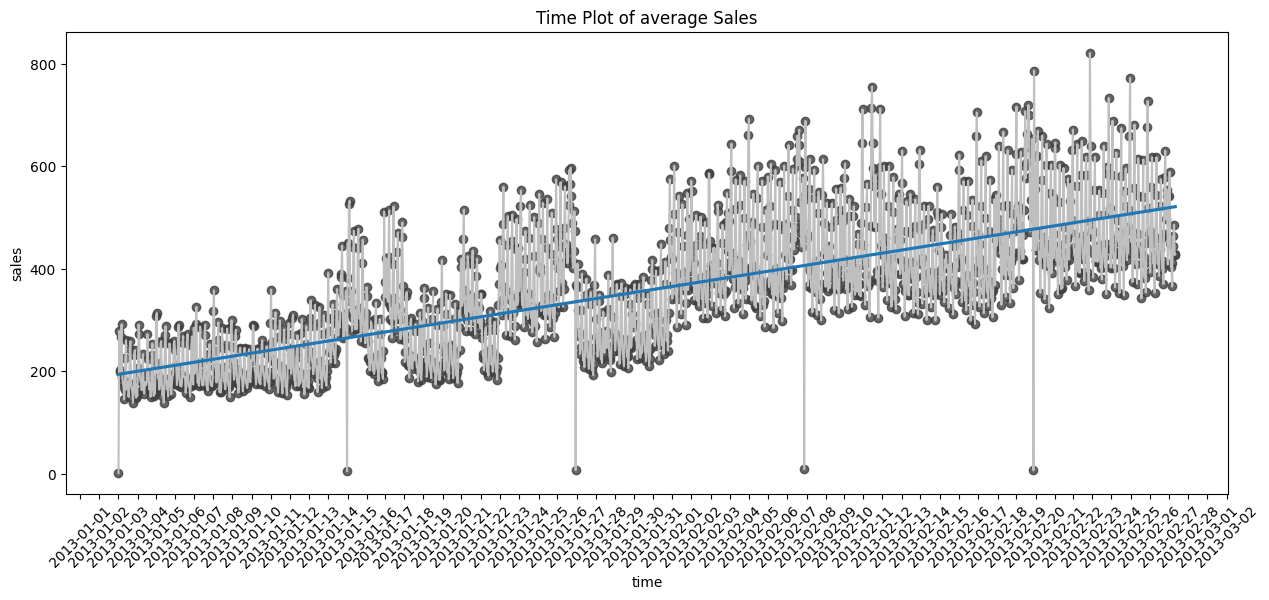

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)

# plot sales data
average_sales['time'] = np.arange(len(average_sales))
ax.plot('time', 'sales', data=average_sales, color='0.75')

# format x-axis
ax.set_xticklabels(average_sales.index.astype(str), rotation=45)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# add regression line
ax = sns.regplot(x='time', y='sales', data=average_sales, ci=None, scatter_kws=dict(color='0.25'))

ax.set_title('Time Plot of average Sales')

# Create base regression model

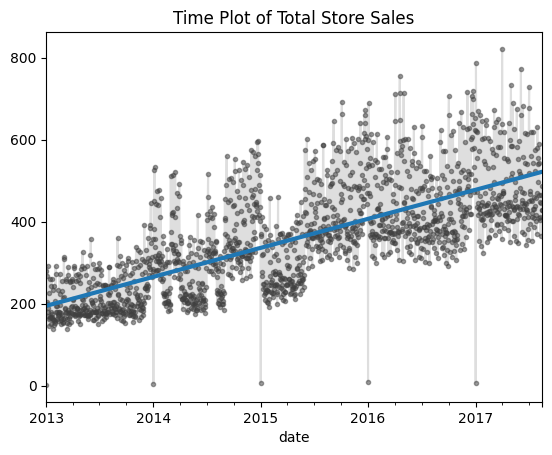

In [65]:
from sklearn.linear_model import LinearRegression

# 
X = average_sales.drop(['sales'], axis=1)  # features
y = average_sales['sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

# Lagged sales plot

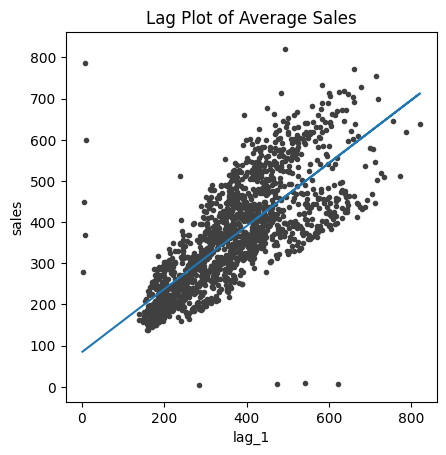

In [67]:
# fit linear regression to lagged sales data
avg_sales['lag_1'] = avg_sales['sales'].shift(1)

X = avg_sales.loc[:, ['lag_1']].dropna()  # features
y = avg_sales.loc[X.index, 'sales']  # target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

# plot results
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

In [69]:
average_sales.drop(['lag_1', 'time'], axis=1, inplace=True)

# Trend analysis

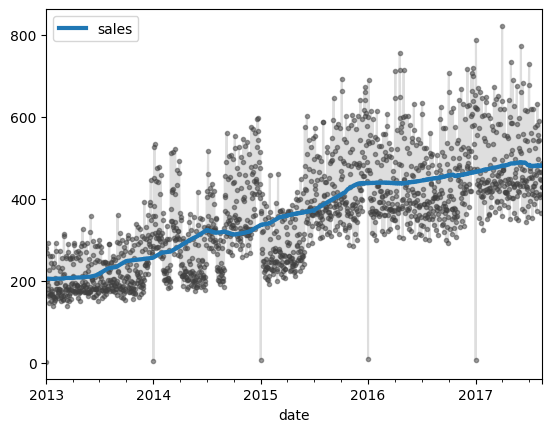

In [75]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

starts with increasing upwards trend, then starts decreasing upwards trend. Polynomial of 3rd degree seems worth pursuing

## 3rd degree polynomial regression

In [114]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales['sales'].copy()  # the target

# Instantiate `DeterministicProcess`
# appropriate for a cubic trend model
dp = DeterministicProcess(index=y.index,  order=3, drop=True)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

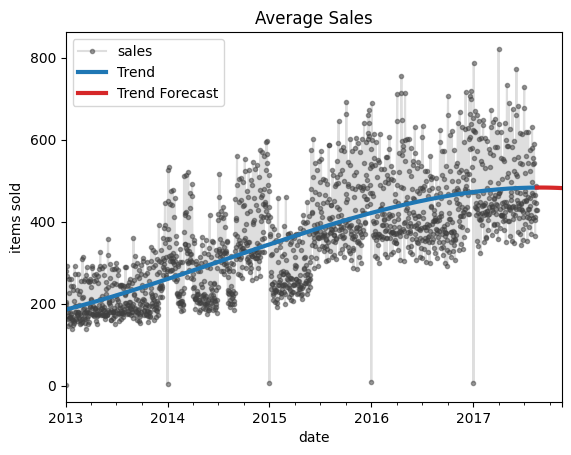

In [117]:
# plot Linear Regression with trend
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

In [122]:
import pyearth

In [125]:
from pyearth import Earth

# Target and features are the same as before
y = average_sales['sales'].copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

ImportError: cannot import name 'Earth' from 'pyearth' (c:\Users\Juan\anaconda3\envs\kaggle-env\lib\site-packages\pyearth\__init__.py)